# Transfer Learning
- Cats and dogs dataset

### Import Section
- [TensorFlow datasets](https://www.tensorflow.org/datasets/overview)

In [2]:
import cv2  # OpenCV library
import numpy as np 
import scipy as sp   # statistical library
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds  # collection of large datasets

from tensorflow.keras.models import Sequential, Model   # sequential and functional API
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model   # plot the model

### Download and Prepare the Dataset

We will use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and we can load it via Tensorflow Datasets. The images are labeled 0 for cats and 1 for dogs.

In [14]:
# label for the dataset
LABEL = ['Cat', 'Dog']

In [3]:
train_data = tfds.load('cats_vs_dogs', split = 'train[:80%]', as_supervised = True)   # this will return tf.data.Dataset
validation_data = tfds.load('cats_vs_dogs', split = 'train[80%:90%]', as_supervised = True)
test_data = tfds.load('cats_vs_dogs', split = 'train[-10%:]', as_supervised = True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteF2DY4T/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [10]:
# check the shape of images
i = 0
for img, label in train_data:
  print(f'Image shape: {img.shape}\t Label: {label.numpy()}')  # tensor.numpy() gives the value of the tensor
  i += 1
  if i == 5:
    break

Image shape: (262, 350, 3)	 Label: 1
Image shape: (409, 336, 3)	 Label: 1
Image shape: (493, 500, 3)	 Label: 1
Image shape: (375, 500, 3)	 Label: 0
Image shape: (240, 320, 3)	 Label: 1


### Display few images

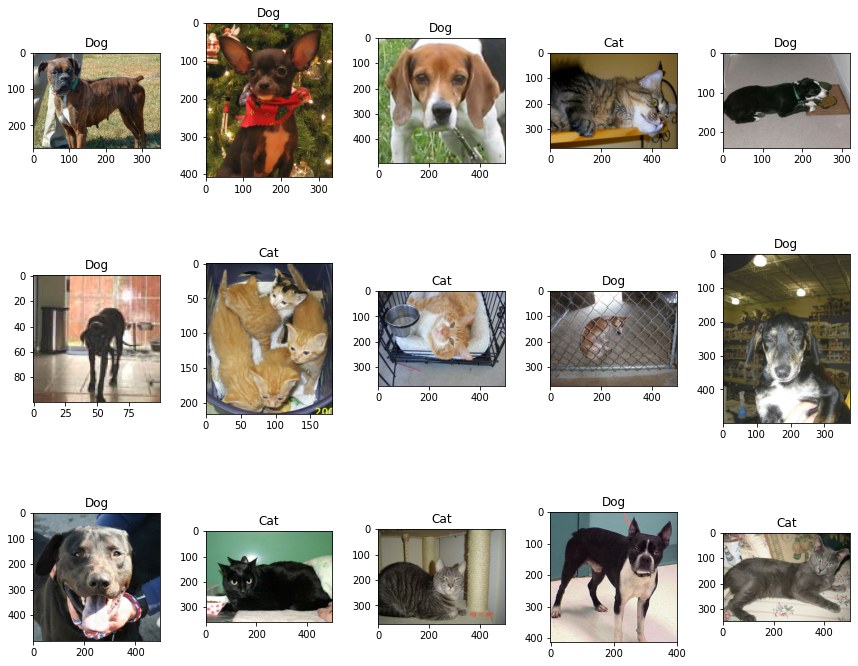

In [17]:
# create figure and axes object
fig, axes = plt.subplots(3, 5, figsize = (12, 10))  # 15 axes objects on a single figure (3 * 5)

for ax, (img, label) in zip(axes.flatten(), train_data):
  ax.imshow(img)
  ax.set_title(LABEL[label])
plt.tight_layout()

The cell below will preprocess the images and create batches before feeding it into the model

In [4]:
def preprocess_images(image, label):
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image / 255)
  # resize to 300 x 300
  image = tf.image.resize(image, (300, 300))
  return image, label

# use the utility function above to preprocess the images
processed_training_data = train_data.map(preprocess_images)

# shuffle and create batches before training
train_batches = processed_training_data.shuffle(1024).batch(32)

In [5]:
# preprocess validation data set
validation_processed = validation_data.map(preprocess_images)
validation_batches = validation_processed.shuffle(1024).batch(32)

In [18]:
# Check the training dataset after creating batches of data
for img_batch, label_batch in train_batches:
  print(f'Shape of image batch: {img_batch.shape}\t Shape of label batch: {label_batch.shape}')
  break

Shape of image batch: (32, 300, 300, 3)	 Shape of label batch: (32,)


### Display images after preprocessing

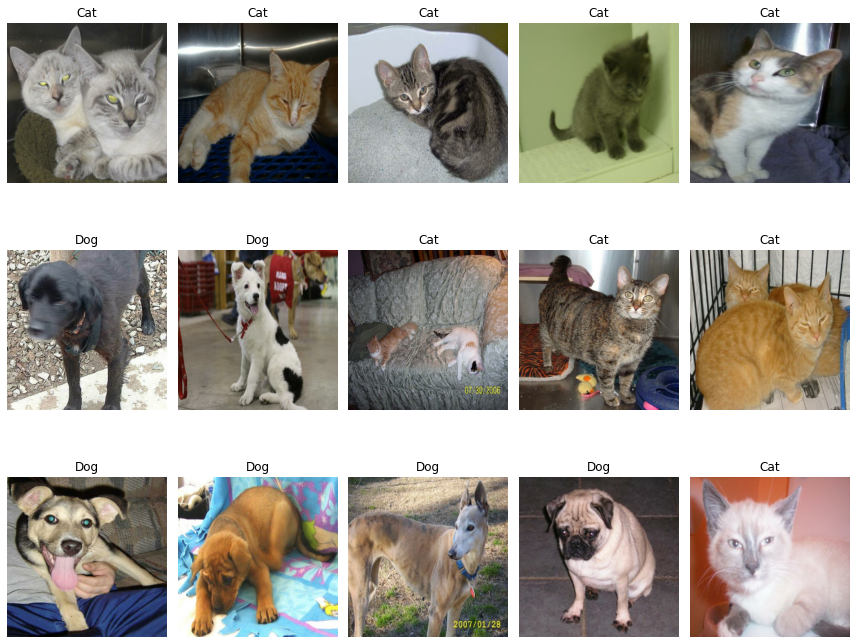

In [21]:
# get a batch of training images and labels
img_batch, label_batch = next(iter(train_batches))  # it will return 32 image-label pairs

# create figure and axes object
fig, axes = plt.subplots(3, 5, figsize = (12, 10))  # 15 axes objects on a single figure (3 * 5)

for i, ax in enumerate(axes.flatten()):  # enumerate gives the index of the data
  ax.imshow(img_batch[i])
  ax.set_title(LABEL[label_batch[i]])
  # ax.axis('off')
plt.tight_layout()

## Build the classifier
- We will build the classifier using both Sequential and Functional API

In [22]:
# Model using sequential API
model = Sequential(name = 'Cats_Dogs_Classifier') 

# add method is used to sequence layers one after the other
model.add(Conv2D(16, input_shape = (300, 300, 3), kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size =(3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))  # filters and kernel_size keywords are omitted
model.add(GlobalAveragePooling2D(name = 'gpool'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "Cats_Dogs_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 12

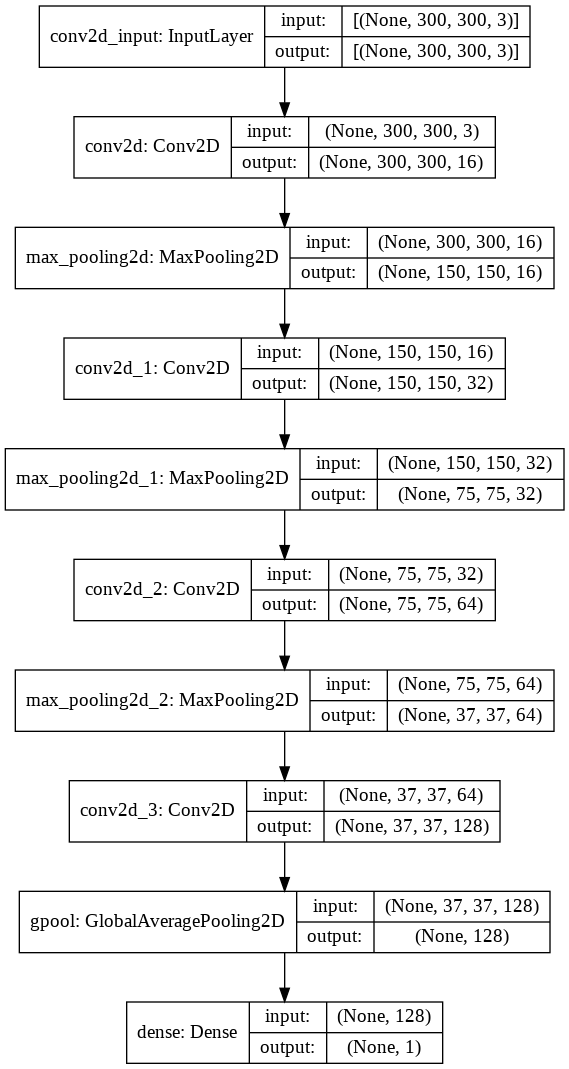

In [23]:
### plot model 
plot_model(model, show_shapes = True, dpi = 96)

In [24]:
# Model using functional API  (same model as above)
inputs = tf.keras.layers.Input(shape = (300, 300, 3), name = 'input_layer')

x = Conv2D(16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs)
x = MaxPooling2D(pool_size = (2, 2))(x)

x = Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)

x = Conv2D(filters = 64, kernel_size =(3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)

x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(x)  # filters and kernel_size keywords are omitted
x = GlobalAveragePooling2D(name = 'gpool')(x)
output = Dense(1, activation = 'sigmoid')(x)

model_func = Model(inputs = inputs, outputs = output, name = 'Functional_Model')

model_func.summary()

Model: "Functional_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)   

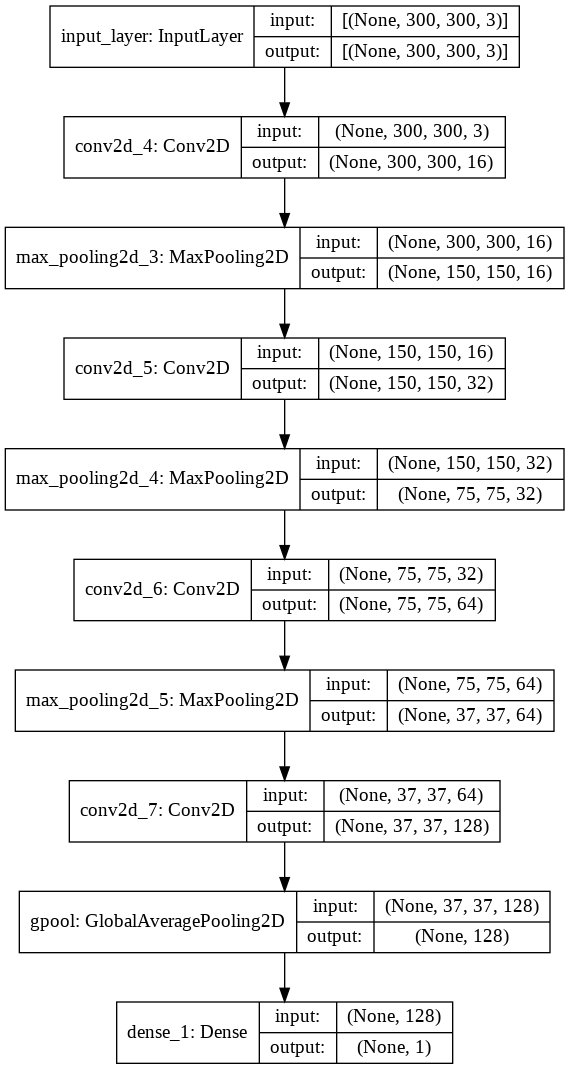

In [25]:
### plot model 
plot_model(model_func, show_shapes = True, dpi = 96)

## Compile the model
- Specify loss, optimizer and metrics 

In [26]:
model.compile(loss = 'binary_crossentropy', 
              metrics=['accuracy'],
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001))

# fit the model
model.fit(train_batches, 
          batch_size = 32,
          epochs = 5,
          validation_data = validation_batches)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
582/582 [==============================] - 99s 112ms/step - loss: 0.6662 - accuracy: 0.5916 - val_loss: 0.6360 - val_accuracy: 0.6457
Epoch 2/5
582/582 [==============================] - 66s 111ms/step - loss: 0.6283 - accuracy: 0.6463 - val_loss: 0.6078 - val_accuracy: 0.6763
Epoch 3/5
582/582 [==============================] - 66s 111ms/step - loss: 0.6042 - accuracy: 0.6794 - val_loss: 0.6242 - val_accuracy: 0.6599
Epoch 4/5
582/582 [==============================] - 66s 111ms/step - loss: 0.5868 - accuracy: 0.6979 - val_loss: 0.5597 - val_accuracy: 0.7120
Epoch 5/5
582/582 [==============================] - 67s 112ms/step - loss: 0.5675 - accuracy: 0.7133 - val_loss: 0.5667 - val_accuracy: 0.7068


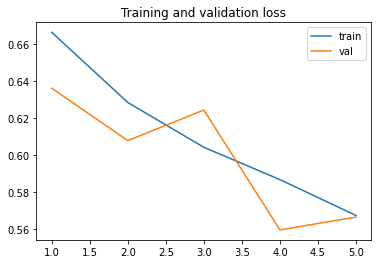

In [30]:
# plot loss and accuracy curves on training and validation data
plt.plot(range(1, 6), model.history.history['loss'],)
plt.plot(range(1, 6), model.history.history['val_loss'])
plt.legend(['train', 'val'])
plt.title('Training and validation loss');

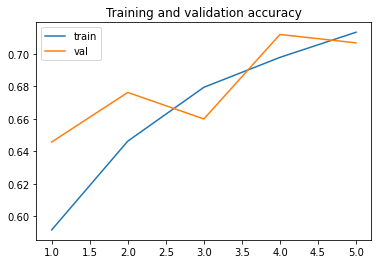

In [31]:
# plot loss and accuracy curves on training and validation data
plt.plot(range(1, 6), model.history.history['accuracy'],)
plt.plot(range(1, 6), model.history.history['val_accuracy'])
plt.legend(['train', 'val'])
plt.title('Training and validation accuracy');

# Transfer learning
- Load a pre-trained InceptionV3 model and remove the classification head.
- Freeze the trained weights and add new classification head.

In [39]:
# base model or feature extractor
base_model = tf.keras.applications.InceptionV3(include_top = False,   # this will remove the fully connected layer (called classification head)
                                               weights = 'imagenet',   # imagenet weights will be loaded
                                               input_shape = (300, 300, 3))  # input shape to the model
  
# freeze the base model
base_model.trainable = False   # base model will not be updated

# add global average pooling layer or flatten layer
x = GlobalAveragePooling2D(name = 'gpool')(base_model.output)

# classification layer
output = Dense(1, activation = 'sigmoid')(x)

# construct model
inception_model = Model(inputs = base_model.inputs, outputs = output, name = 'Inception')

# print model summary
inception_model.summary()

Model: "Inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_384 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 149, 149, 32) 96          conv2d_384[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 149, 149, 32) 0           batch_normalization_376[0][0]    
__________________________________________________________________________________________

### Compile and fit the model

In [40]:
inception_model.compile(loss = 'binary_crossentropy', 
                        metrics=['accuracy'],
                        optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001))

# fit the model
inception_model.fit(train_batches, 
                    batch_size = 32, 
                    epochs = 2,
                    validation_data = validation_batches)

Epoch 1/2
582/582 [==============================] - 128s 209ms/step - loss: 0.0425 - accuracy: 0.9899 - val_loss: 0.0221 - val_accuracy: 0.9931
Epoch 2/2
582/582 [==============================] - 113s 191ms/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.0225 - val_accuracy: 0.9931


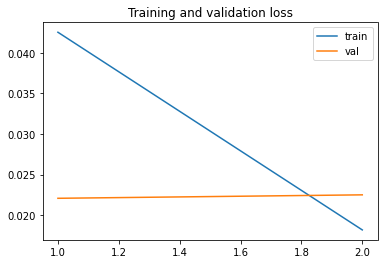

In [41]:
# plot loss and accuracy curves on training and validation data
plt.plot(range(1, 3), inception_model.history.history['loss'],)
plt.plot(range(1, 3), inception_model.history.history['val_loss'])
plt.legend(['train', 'val'])
plt.title('Training and validation loss');

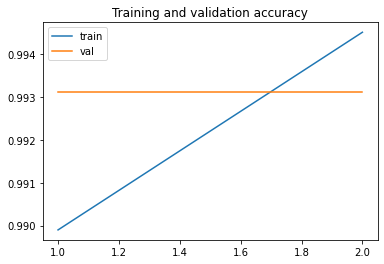

In [42]:
# plot loss and accuracy curves on training and validation data
plt.plot(range(1, 3), inception_model.history.history['accuracy'],)
plt.plot(range(1, 3), inception_model.history.history['val_accuracy'])
plt.legend(['train', 'val'])
plt.title('Training and validation accuracy');

## Building the CAM model

In [44]:
gap_weights = inception_model.layers[-1].get_weights()[0]   # global average pooling
gap_weights.shape

(2048, 1)

In [45]:
cam_model  = Model(inputs = inception_model.input, 
                   outputs = (inception_model.layers[-3].output, inception_model.layers[-1].output))

# print the summary of the model
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_384 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 149, 149, 32) 96          conv2d_384[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 149, 149, 32) 0           batch_normalization_376[0][0]    
______________________________________________________________________________________________

In [46]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 8, 8, 2048)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:, 0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/8, 300/8, 1), order = 2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features, class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize = (8, 8))
  plt.imshow(cam_output, cmap = 'jet', alpha = 0.5)
  plt.imshow(tf.squeeze(image_value), alpha = 0.5)
  plt.show()

## Testing the Model

Let's download a few images and see how the class activation maps look like.

In [47]:
!wget -O cat1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
!wget -O cat2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
!wget -O catanddog.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/catanddog.jpg
!wget -O dog1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg
!wget -O dog2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg

--2021-06-03 01:06:10--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.80, 172.217.9.208, 172.217.12.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.003s  

2021-06-03 01:06:10 (143 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2021-06-03 01:06:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.208, 142.250.65.80, 172.217.9.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.

sigmoid output: [[0.00010342]]
prediction: cat


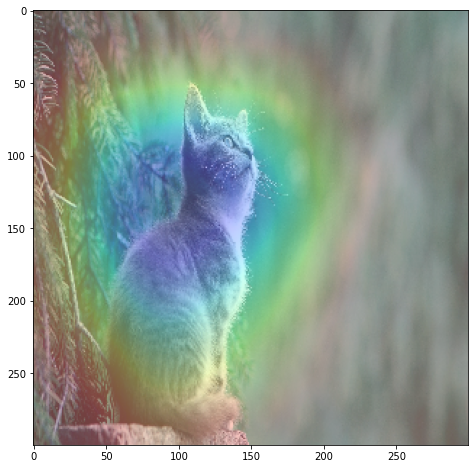

sigmoid output: [[1.1569805e-06]]
prediction: cat


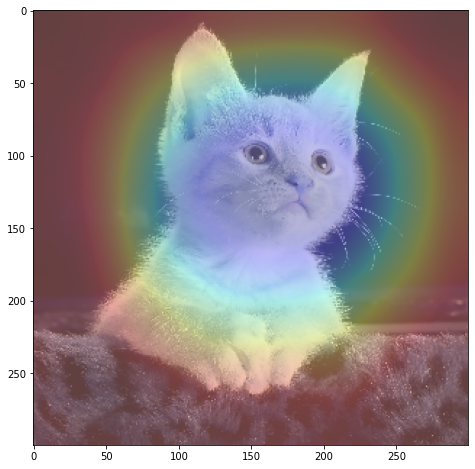

sigmoid output: [[0.9705108]]
prediction: dog


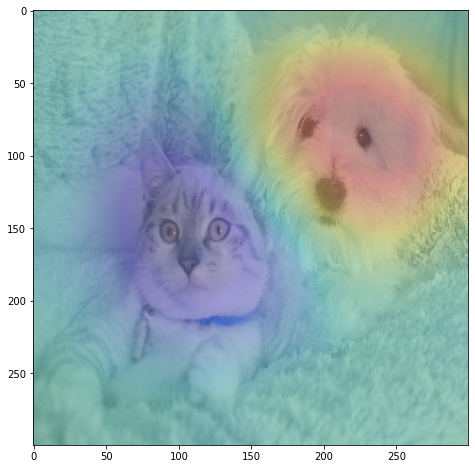

sigmoid output: [[0.99989593]]
prediction: dog


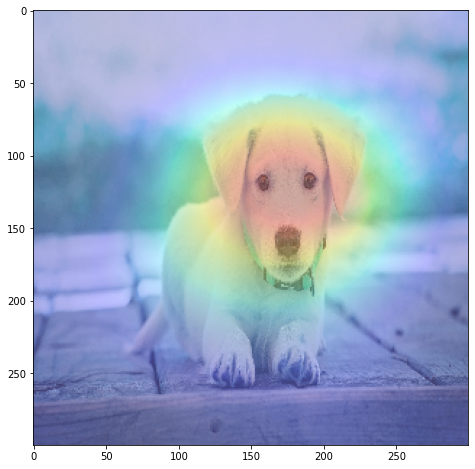

sigmoid output: [[0.99747556]]
prediction: dog


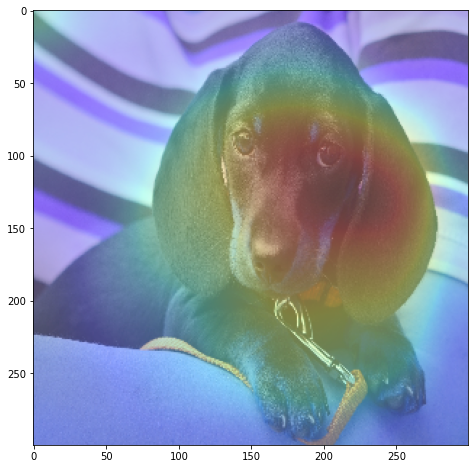

In [48]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300, 300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis = 0)

  # get the features and prediction
  features, results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

ground truth: cat
sigmoid output: [[0.00114256]]
prediction: cat


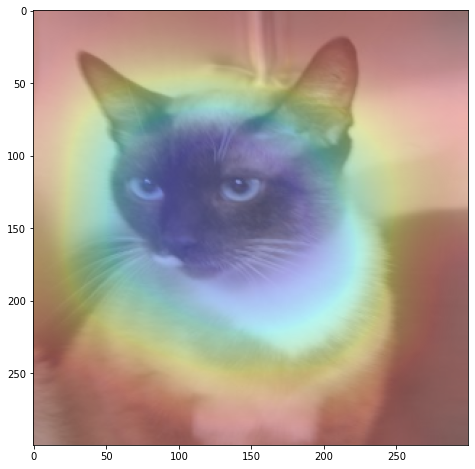

ground truth: dog
sigmoid output: [[0.99903893]]
prediction: dog


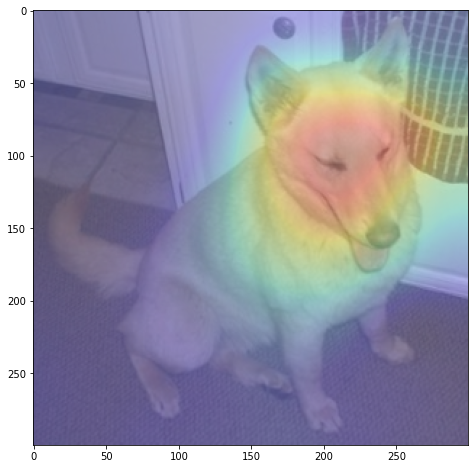

ground truth: dog
sigmoid output: [[0.99879754]]
prediction: dog


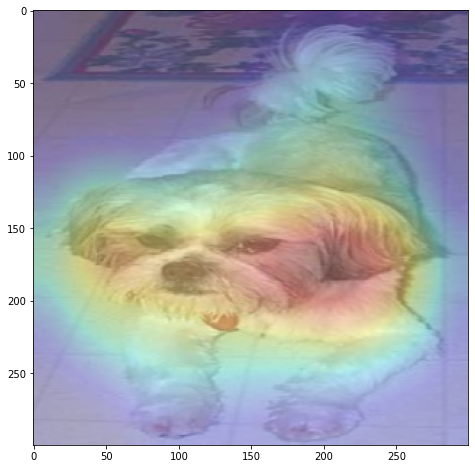

ground truth: cat
sigmoid output: [[1.3004623e-05]]
prediction: cat


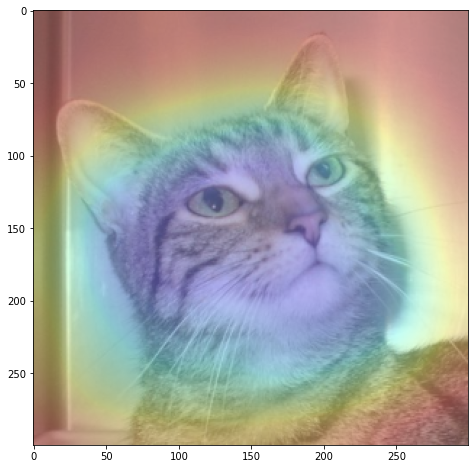

ground truth: cat
sigmoid output: [[6.300692e-05]]
prediction: cat


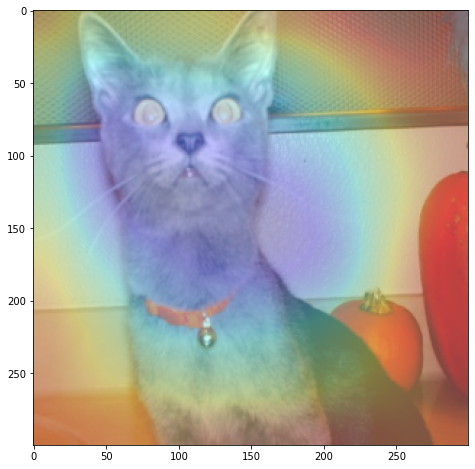

In [49]:
# preprocess the test images
processed_test_data = test_data.map(preprocess_images)
test_batches = processed_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)